In [1]:
import os # Proporciona funciones para interactuar con el sistema operativo.
import pandas as pd # Manipulación y análisis de datos tabulares (filas y columnas).
import numpy as np # Operaciones numéricas y matriciales.
import seaborn as sns # Visualización estadística de datos.
import matplotlib.pyplot as plt # Creación de gráficos y visualizaciones.
import scipy.cluster.hierarchy as sch

from sklearn.decomposition import PCA # Implementación del Análisis de Componentes Principales (PCA).
from sklearn.preprocessing import StandardScaler # Estandarización de datos para análisis estadísticos.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [2]:
# Establecemos nuestro escritorio de trabajo
os.chdir('C:\\Users\\angel\\OneDrive - Universidad Complutense de Madrid (UCM)\\Documentos Compartidos\\Master\\Tareas_Master\\MineriaDeDatos\\Parte2')

In [3]:
import FuncionesMineria2 as fm2
import FuncionesMineria as fm

In [4]:
# Cargo los datos
datos = sns.load_dataset('penguins')

In [5]:
# Comprobamos el tipo de formato de las variables variable que se ha asignado en la lectura
datos.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [6]:
# Genera una lista con los nombres de las variables.
variables = list(datos.columns)

In [7]:
# Comprobamos el número de valores distintos en cada variable
fm.cuentaDistintos(datos)

,Columna,Distintos
0,bill_length_mm,165
1,bill_depth_mm,81
2,flipper_length_mm,56
3,body_mass_g,95


In [8]:
# Seleccionar las columnas numéricas del DataFrame
numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns.to_list()

In [9]:
# Seleccionar las columnas categóricas del DataFrame
categoricas = [variable for variable in variables if variable not in numericas]

In [10]:
# Frecuencias de los valores en las variables categóricas
fm.analizar_variables_categoricas(datos)

{'species':              n         %
 Adelie     152  0.441860
 Gentoo     124  0.360465
 Chinstrap   68  0.197674,
 'island':              n         %
 Biscoe     168  0.488372
 Dream      124  0.360465
 Torgersen   52  0.151163,
 'sex':           n         %
 Male    168  0.504505
 Female  165  0.495495}

In [11]:
# Descriptivos variables numéricas mediante función describe() de Python
descriptivos_num = datos.describe().T

# Añadimos más descriptivos a los anteriores
for num in numericas:
    descriptivos_num.loc[num, "Asimetria"] = datos[num].skew()
    descriptivos_num.loc[num, "Kurtosis"] = datos[num].kurtosis()
    descriptivos_num.loc[num, "Mediana"] = datos[num].median()
    descriptivos_num.loc[num, "Rango"] = np.ptp(datos[num].dropna().values)

In [12]:
descriptivos_num

,count,mean,std,min,25%,50%,75%,max,Asimetria,Kurtosis,Mediana,Rango
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6,0.053118,-0.876027,44.45,27.5
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5,-0.143465,-0.906866,17.30,8.4
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0,0.345682,-0.984273,197.00,59.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0,0.470329,-0.719222,4050.00,3600.0


In [13]:
# Muestra valores perdidos
datos[variables].isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

# Comenzamos con la depuración de los datos

In [14]:
# A veces los 'nan' vienen como como una cadena de caracteres, los modificamos a perdidos.
for x in categoricas:
    datos[x] = datos[x].replace('nan', np.nan) 

In [15]:
# La proporción de valores atípicos se calcula dividiendo la cantidad de valores atípicos por el número total de filas
resultados = {x: fm.atipicosAmissing(datos[x])[1] / len(datos) for x in numericas}

# Modifico los atipicos como missings
for x in numericas:
    datos[x] = fm.atipicosAmissing(datos[x])[0]

In [16]:
# Muestra proporción de valores perdidos por cada variable (guardo la información)
prop_missingsVars = datos.isna().sum()/len(datos)

In [17]:
# Creamos la variable prop_missings que recoge el número de valores perdidos por cada observación
datos['prop_missings'] = datos.isna().mean(axis = 1)

In [18]:
# Realizamos un estudio descriptivo básico a la nueva variable
datos['prop_missings'].describe()

count    344.000000
mean       0.007890
std        0.058720
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.714286
Name: prop_missings, dtype: float64

In [19]:
# Calculamos el número de valores distintos que tiene la nueva variable
len(datos['prop_missings'].unique())

3

In [20]:
# Elimino las observaciones con mas de la mitad de datos missings (hay 2)
eliminar = datos['prop_missings'] > 0.5
datos = datos[~eliminar]

In [21]:
# Transformo la nueva variable en categórica (ya que tiene pocos valores diferentes)
datos["prop_missings"] = datos["prop_missings"].astype(str)

In [22]:
# Elimino las variables con mas de la mitad de datos missings (no hay ninguna)
eliminar = [prop_missingsVars.index[x] for x in range(len(prop_missingsVars)) if prop_missingsVars[x] > 0.5]
datos = datos.drop(eliminar, axis = 1)

In [23]:
# Agrego 'prop_missings' a la lista de nombres de variables input
variables.append('prop_missings')
categoricas.append('prop_missings')

# Imputaciones

In [24]:
# Imputo todas las cualitativas, seleccionar el tipo de imputacion: moda o aleatorio
for x in categoricas:
    datos[x] = fm.ImputacionCuali(datos[x], 'aleatorio')

In [25]:
# Muestra valores perdidos que nos quedan
datos[variables].isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
prop_missings        0
dtype: int64

In [26]:
# Frecuencias de los valores en las variables categóricas
fm.analizar_variables_categoricas(datos)

{'species':              n         %
 Adelie     151  0.441520
 Gentoo     123  0.359649
 Chinstrap   68  0.198830,
 'island':              n         %
 Biscoe     167  0.488304
 Dream      124  0.362573
 Torgersen   51  0.149123,
 'sex':           n         %
 Male    172  0.502924
 Female  170  0.497076,
 'prop_missings':                        n         %
 0.0                  333  0.973684
 0.14285714285714285    9  0.026316}

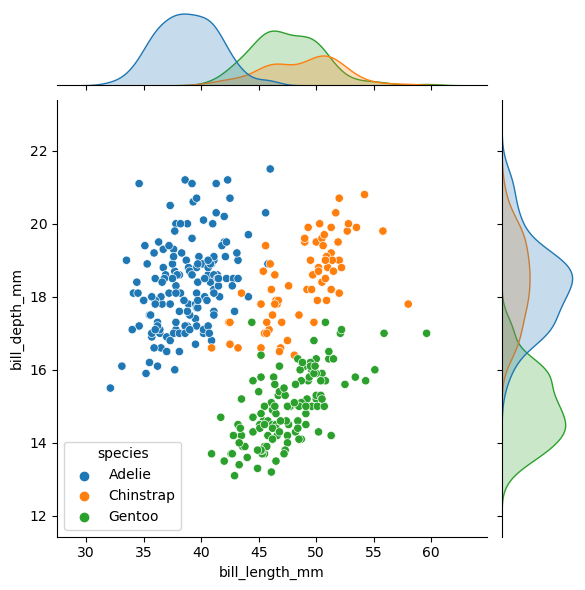

In [27]:
sns.jointplot(data=datos, x="bill_length_mm", y="bill_depth_mm", hue="species")
plt.show()

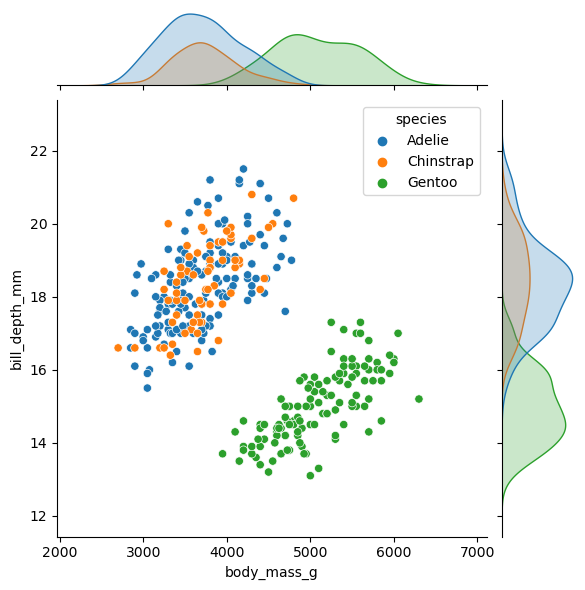

In [28]:
sns.jointplot(data=datos, x="body_mass_g", y="bill_depth_mm", hue="species")
plt.show()

In [29]:
# Calcula y representación de la matriz de correlación entre las 
# variables del DataFrame 'notas'.
R = datos.corr()

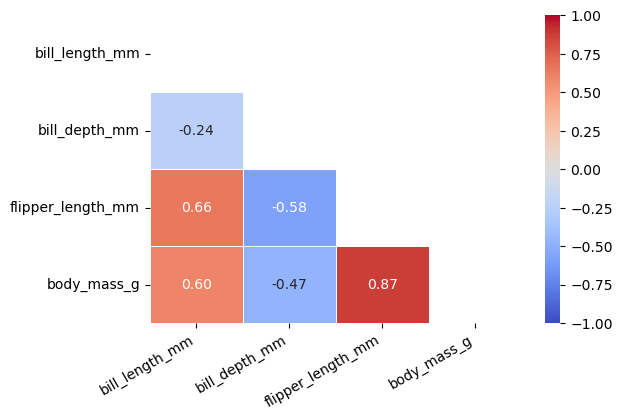

In [30]:
# Crea una nueva figura de tamaño 10x8 pulgadas para el gráfico.
plt.figure(figsize=(6, 4))

# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(R, dtype=bool))

# Genera un mapa de calor (heatmap) de la matriz de correlación 'R' utilizando Seaborn.
# 'annot=True' agrega los valores de correlación en las celdas.
# 'cmap' establece el esquema de colores (en este caso, 'coolwarm' para colores fríos y cálidos).
# 'fmt' controla el formato de los números en las celdas ('.2f' para dos decimales).
# 'linewidths' establece el ancho de las líneas que separan las celdas.
# 'mask' establece unna mascara para la matriz
# 'vmin' establece el valor minimo de la matriz
# 'vmax' establece el valor maximo de la matriz
sns.heatmap(R, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask, vmin=-1, vmax=1)
plt.xticks(rotation=30, ha='right')
plt.show()

# Analisis PCA

In [31]:
# Estandarizamos los datos:
# Utilizamos StandardScaler() para estandarizar (normalizar) las variables.
# - StandardScaler calcula la media y la desviación estándar de las variables numéricas durante el ajuste.
# - Luego, utiliza estos valores para transformar las variables numéricas de manera que tengan media 0 y desviación estándar 1.
# - El método fit_transform() realiza ambas etapas de ajuste y transformación en una sola llamada.
# Finalmente, convertimos la salida en un DataFrame usando pd.DataFrame().
datos_estandarizados = pd.DataFrame(
    StandardScaler().fit_transform(datos[numericas]),  # Datos estandarizados
    columns=['{}_z'.format(numericas) for numericas in numericas],  # Nombres de columnas estandarizadas
    index=datos[numericas].index  # Índices (etiquetas de filas) del DataFrame
)

numericas_estandarizados = datos_estandarizados.columns.to_list()

In [32]:
# Crea una instancia de Análisis de Componentes Principales (ACP):
# - Utilizamos PCA(n_components=4) para crear un objeto PCA que realizará un análisis de componentes principales.
# - Establecemos n_components en 4 para retener el maximo de las componentes principales (maximo= numero de variables).
pca = PCA(n_components=4)

In [33]:
# Aplicar el Análisis de Componentes Principales (ACP) a los datos estandarizados:
# - Usamos pca.fit(notas_estandarizadas) para ajustar el modelo de ACP a los datos estandarizados.
fit = pca.fit(datos_estandarizados)

In [34]:
# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_

# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada = fit.explained_variance_ratio_*100

# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada = np.cumsum(var_explicada)

In [35]:
# Crear un DataFrame de pandas con los datos anteriores y establecer índice.
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada, 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)]) 

In [36]:
resultados_pca = pd.DataFrame(fit.transform(datos_estandarizados), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_estandarizados.index)

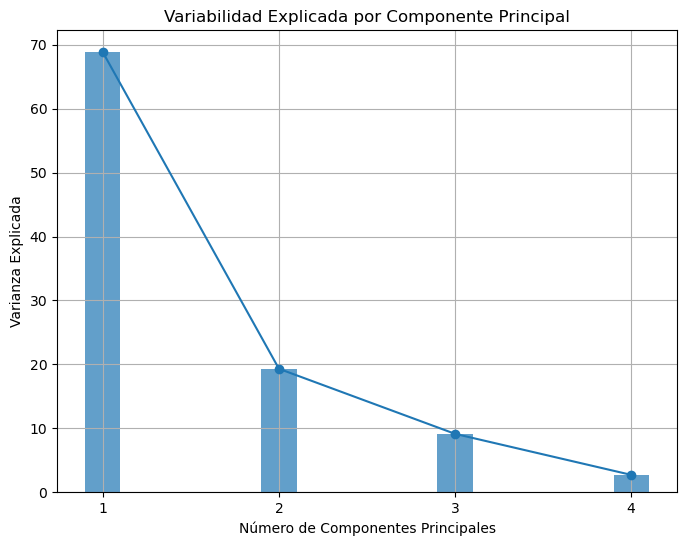

In [37]:
fm2.plot_varianza_explicada(var_explicada, fit.n_components_)

In [38]:
for x in range(0,len(autovalores)):
    print(f'Componente {x+1}: {autovalores[x].round(2)}')

Componente 1: 2.76
Componente 2: 0.77
Componente 3: 0.37
Componente 4: 0.11


In [39]:
for x in range(0,len(var_explicada)):
    print(f'Varianza explicada {x+1}: {var_explicada[x].round(2)}')

Varianza explicada 1: 68.84
Varianza explicada 2: 19.31
Varianza explicada 3: 9.13
Varianza explicada 4: 2.71


In [40]:
# Crea una instancia de ACP con las dos primeras componentes que nos interesan y aplicar a los datos.
pca = PCA(n_components=2)
fit = pca.fit(datos_estandarizados)

In [41]:
# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_

# Obtener los autovectores asociados a cada componente principal y transponerlos.
autovectores = pd.DataFrame(pca.components_.T, 
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in numericas])

# Calculamos las dos primeras componentes principales
resultados_pca = pd.DataFrame(fit.transform(datos_estandarizados), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_estandarizados.index)

# Añadimos las componentes principales a la base de datos estandarizada.
notas_z_cp = pd.concat([datos_estandarizados, resultados_pca], axis=1)

In [42]:
# Cálculo de las correlaciones entre las variables originales y las componentes seleccionadas.
# Guardamos el nombre de las variables del archivo conjunto (variables y componentes).
variables_cp = notas_z_cp.columns

# Calculamos las correlaciones y seleccionamos las que nos interesan (variables contra componentes).
correlacion = pd.DataFrame(np.corrcoef(datos_estandarizados.T, resultados_pca.T), 
                           index = variables_cp, columns = variables_cp)

n_variables = fit.n_features_in_
correlaciones_notas_con_cp = correlacion.iloc[:fit.n_features_in_, fit.n_features_in_:]

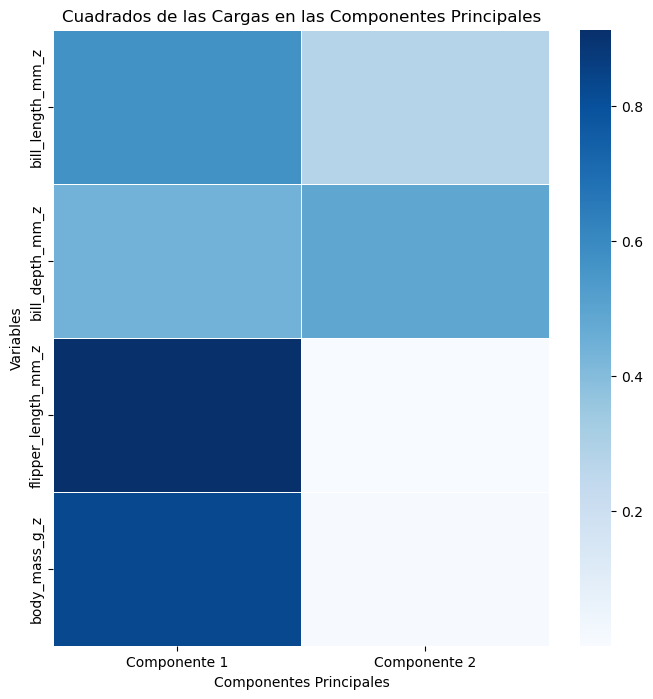

In [43]:
cos2 = correlaciones_notas_con_cp **2
fm2.plot_cos2_heatmap(cos2)

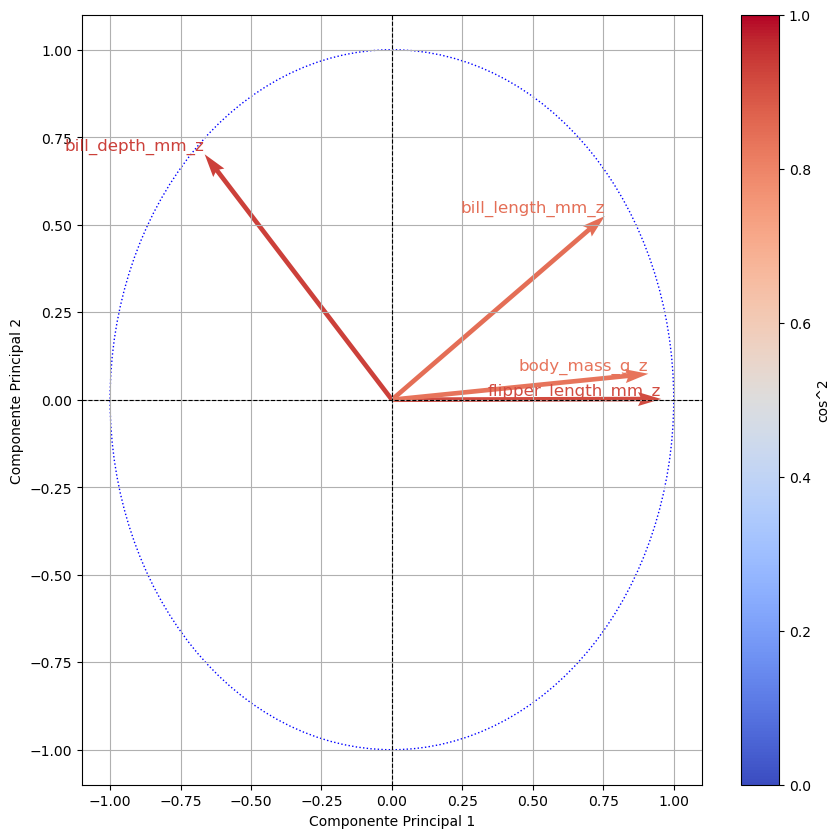

In [44]:
fm2.plot_corr_cos(fit.n_components, correlaciones_notas_con_cp)

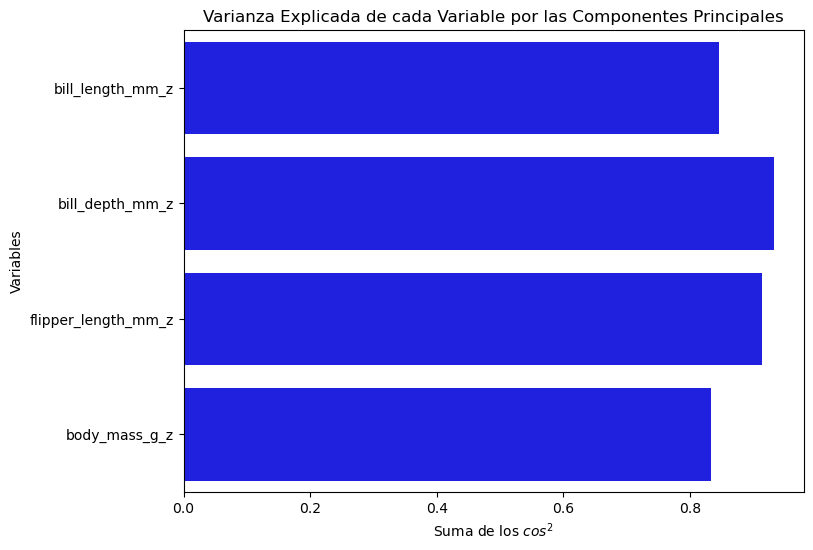

In [45]:
fm2.plot_cos2_bars(cos2)

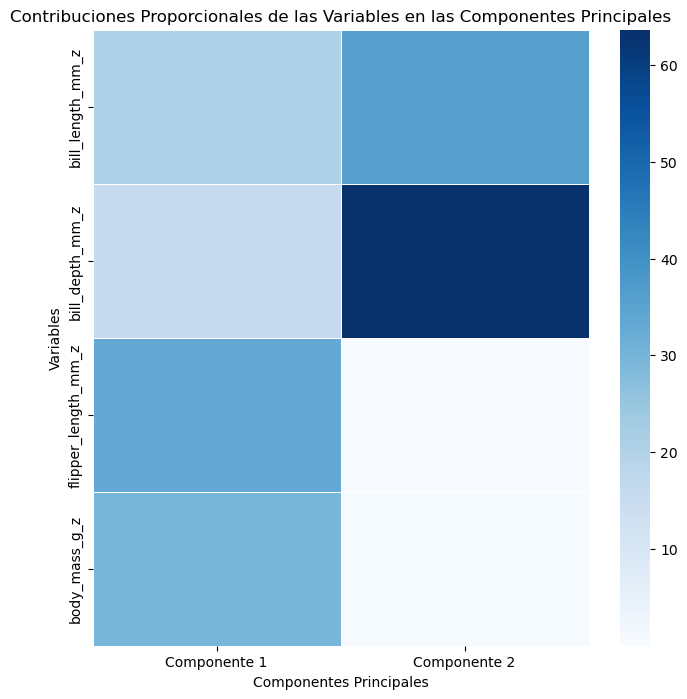

In [46]:
contribuciones_proporcionales = fm2.plot_contribuciones_proporcionales(cos2,autovalores,fit.n_components)

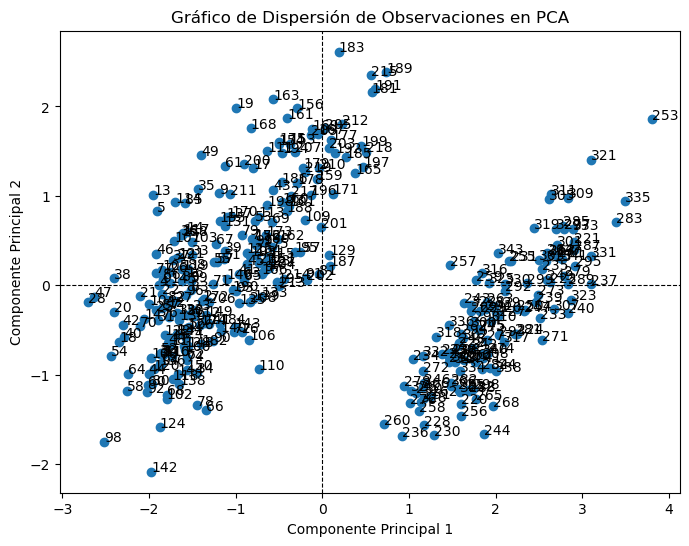

In [47]:
fm2.plot_pca_scatter(pca, datos_estandarizados, fit.n_components)

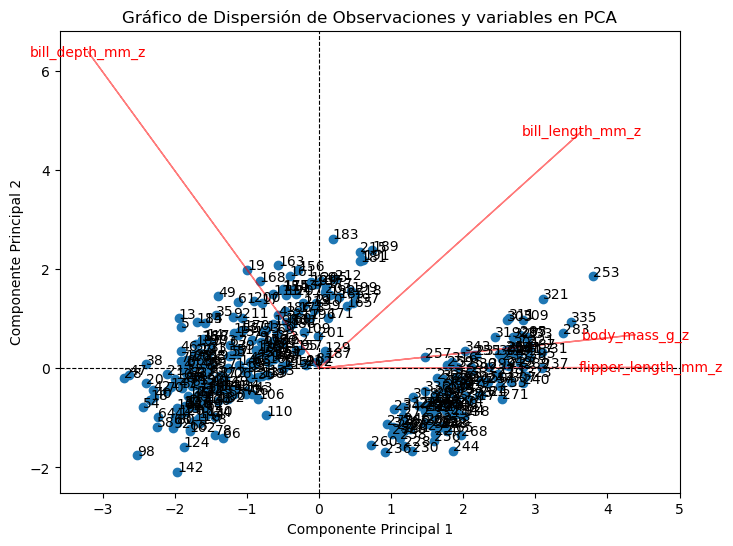

In [48]:
fm2.plot_pca_scatter_with_vectors(pca, datos_estandarizados, fit.n_components, fit.components_)

# Analisis Clustering

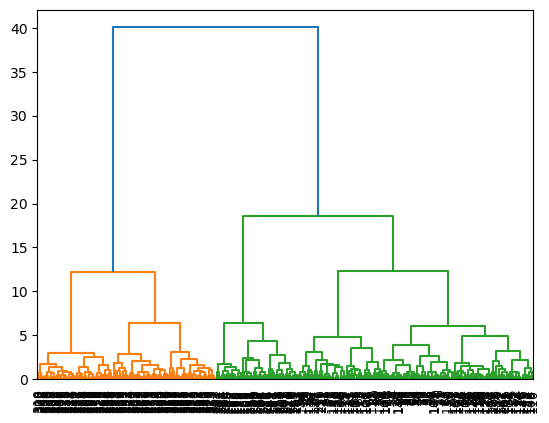

In [49]:
# Calculate the linkage matrix
linkage_matrix = sch.linkage(datos_estandarizados, method='ward')  # You can choose a different linkage method if needed

# Create the dendrogram
dendrogram = sch.dendrogram(linkage_matrix, labels=datos_estandarizados.index, leaf_font_size=9, leaf_rotation=90)

# Display the dendrogram
plt.show()

In [55]:
# Assign data points to 4 clusters
num_clusters = 4
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Display the cluster assignments
print("Cluster Assignments:", cluster_assignments)

# Display the dendrogram
plt.show()

Cluster Assignments: [4 4 4 4 3 4 3 4 3 4 4 4 3 3 4 4 3 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4
 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 4 4 3 4 3 4 4 4 3 4 4 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3
 4 3 3 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 4 4 4 4 4 3 4 4
 4 4 3 2 2 2 2 2 2 4 2 3 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 4 2 4 2
 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 3 2 2 2 2 3 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [56]:
# Create a new column 'Cluster' and assign the 'cluster_assignments' values to it
datos_estandarizados['Cluster'] = cluster_assignments

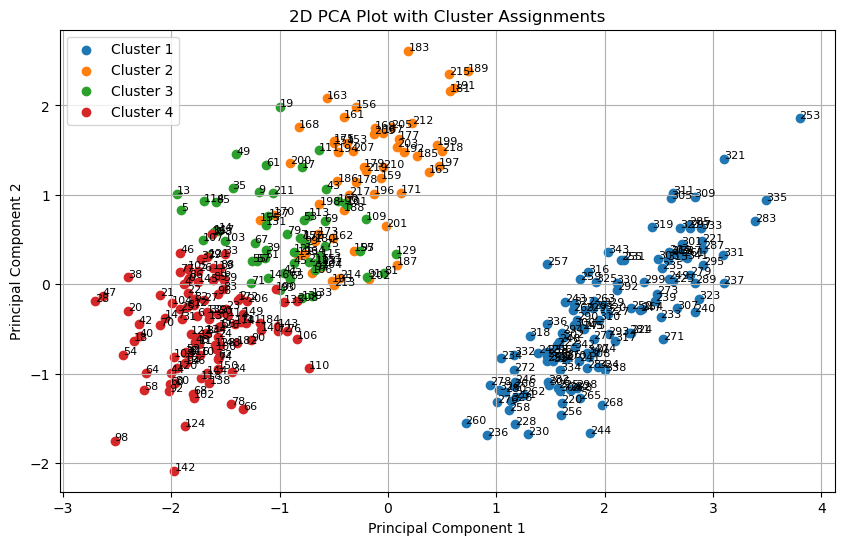

In [57]:
# Assuming 'df' is your original DataFrame with data
# 'cluster_assignments' contains cluster assignments

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(datos_estandarizados[numericas_estandarizados])

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster, 'PC1'],
                df_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

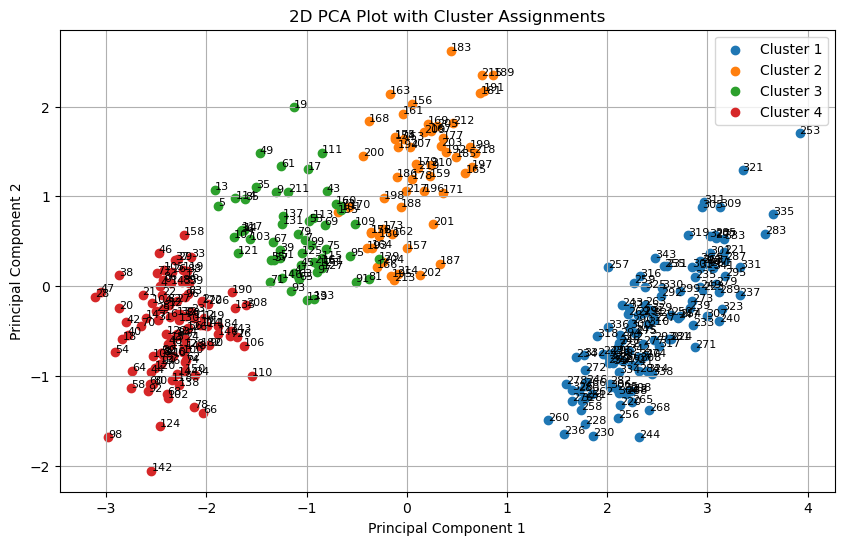

In [58]:
# Assuming 'df' is your original DataFrame with data
# 'cluster_assignments' contains cluster assignments

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(datos_estandarizados)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster, 'PC1'],
                df_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [59]:
# Set the number of clusters (k=4)
k = 4

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the KMeans model to your standardized data
kmeans.fit(datos_estandarizados)

# Get the cluster labels for your data
kmeans_cluster_labels = kmeans.labels_

print(kmeans_cluster_labels)


[2 2 2 2 3 2 3 2 3 2 2 2 3 3 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2
 2 3 2 3 2 3 2 3 2 2 2 3 2 3 2 3 2 3 2 3 2 2 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2
 3 2 2 2 3 2 3 2 2 2 3 2 2 2 2 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 2 2 3 2 3 2 3
 2 3 3 3 2 3 2 2 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 2 2 3 2 3 2 2 2 2 2 2 3 2 2
 2 2 3 0 0 0 0 0 0 2 0 3 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 2 0 2 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 3 0 0 0 0 3 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


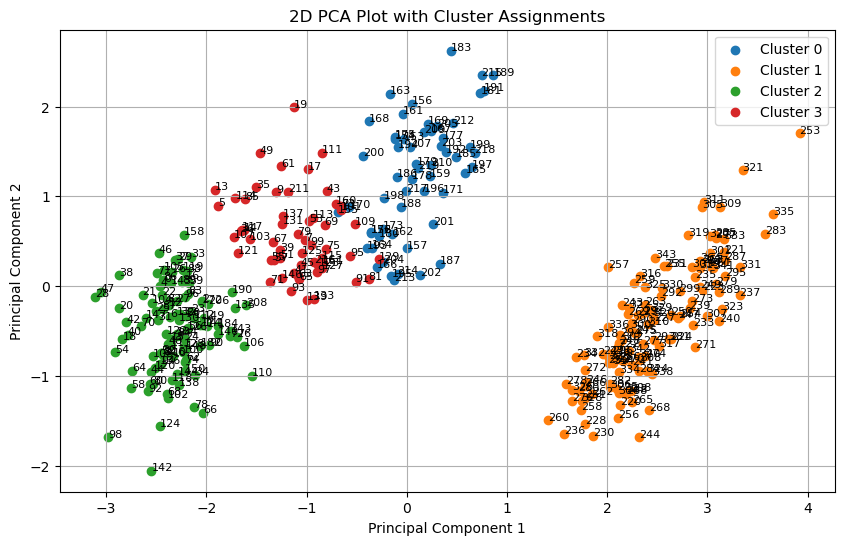

In [60]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(df_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                df_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [61]:
#Create an array to store the WCSS values for different values of K:
wcss = []

for k in range(1, 11):  # You can choose a different range of K values
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_estandarizados)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

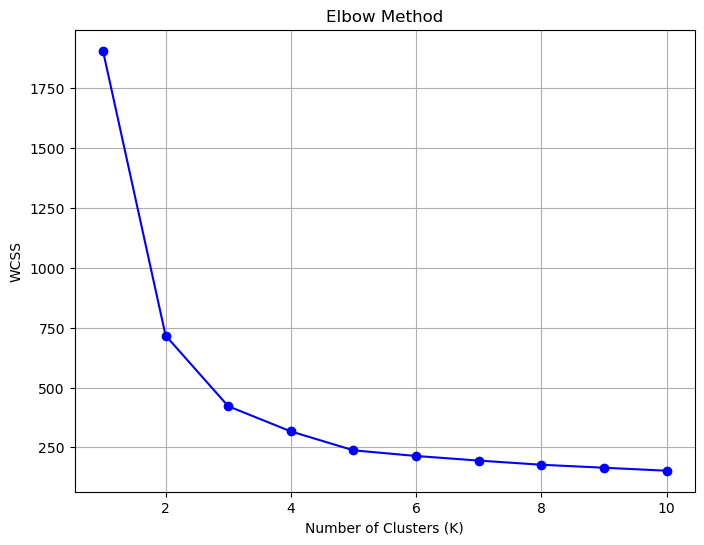

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

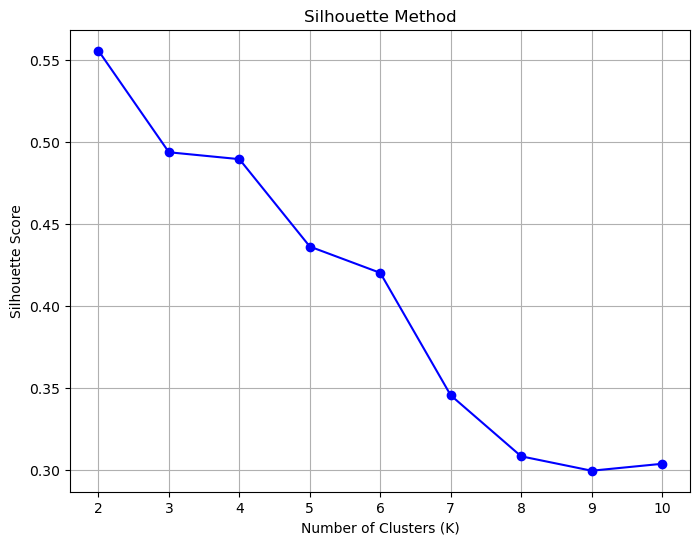

In [63]:
#Create an array to store silhouette scores for different values of K

silhouette_scores = []

#Run K-means clustering for a range of K values and calculate the silhouette score for each K:

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_estandarizados)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(datos_estandarizados, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [64]:
# Assuming 'df_std_distance' is your standardized data and '4' is the optimal number of clusters
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(datos_estandarizados)
labels = kmeans.labels_

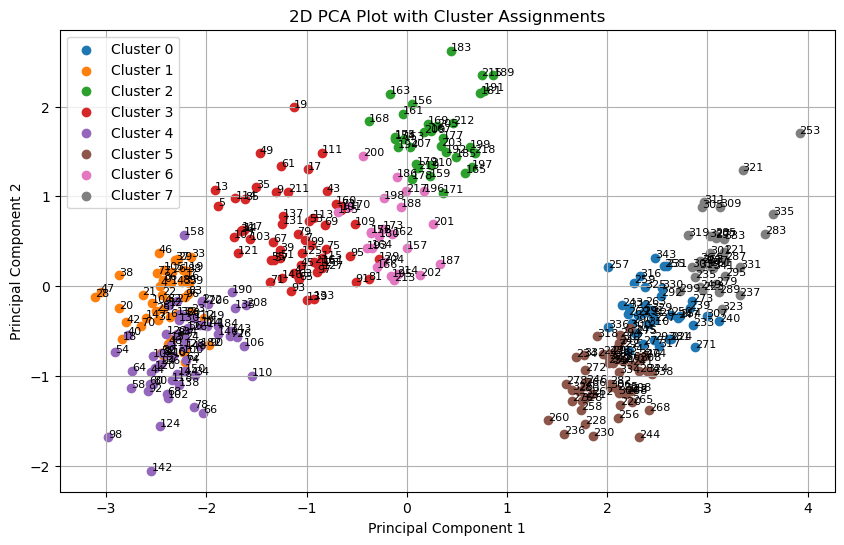

In [65]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(labels):
    plt.scatter(df_pca.loc[labels == cluster, 'PC1'],
                df_pca.loc[labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [66]:
silhouette_values = silhouette_samples(datos_estandarizados, labels)
silhouette_values

array([ 0.35018399,  0.02903783,  0.06106193,  0.38039301,  0.2107966 ,
        0.07668334,  0.42953231,  0.1933723 ,  0.4495714 ,  0.30508997,
        0.0210799 ,  0.17543421,  0.23459803,  0.21062881,  0.18167141,
        0.29086931,  0.47237132,  0.2253471 ,  0.18673399,  0.1472052 ,
        0.35184372,  0.45163922,  0.27707781,  0.04005073,  0.42770255,
        0.24434542,  0.12016895,  0.11882523,  0.30204154,  0.27839032,
        0.23790811,  0.1169971 ,  0.30983971,  0.20659858,  0.37383084,
        0.29167259,  0.12827673,  0.3392614 ,  0.28910485, -0.0424682 ,
        0.3718166 ,  0.16281217,  0.45477554,  0.33580976,  0.37846451,
        0.24611527,  0.15993787,  0.13357808,  0.39045749,  0.06038468,
        0.36138258,  0.14724145,  0.50591205, -0.0182308 ,  0.2614074 ,
        0.10437056,  0.33324361,  0.30068067,  0.39207519,  0.28489641,
        0.43167964,  0.1967836 ,  0.36573446,  0.27078303,  0.3220681 ,
        0.26341312,  0.37320948,  0.32799564,  0.52642388,  0.34

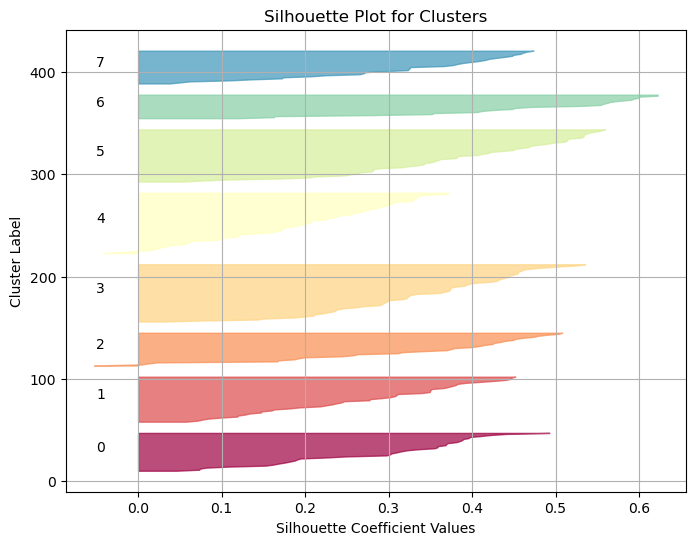

In [67]:
plt.figure(figsize=(8, 6))

y_lower = 10
for i in range(8):
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.get_cmap("Spectral")(float(i) / 8)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.grid(True)
plt.show()

In [68]:
# Add the labels as a new column to the DataFrame
datos_estandarizados['label'] = labels

numericas_estandarizados = numericas_estandarizados.__add__(['label'])

In [69]:
# Sort the DataFrame by the "label" column
datos_estandarizados_sort = datos_estandarizados[numericas_estandarizados].sort_values(by="label")
# Set the 'A' column as the index
datos_estandarizados_sort['label']

343    0
263    0
259    0
257    0
255    0
      ..
237    7
321    7
299    7
303    7
287    7
Name: label, Length: 342, dtype: int32

In [70]:
arrLabel = np.array(datos_estandarizados_sort['label'])

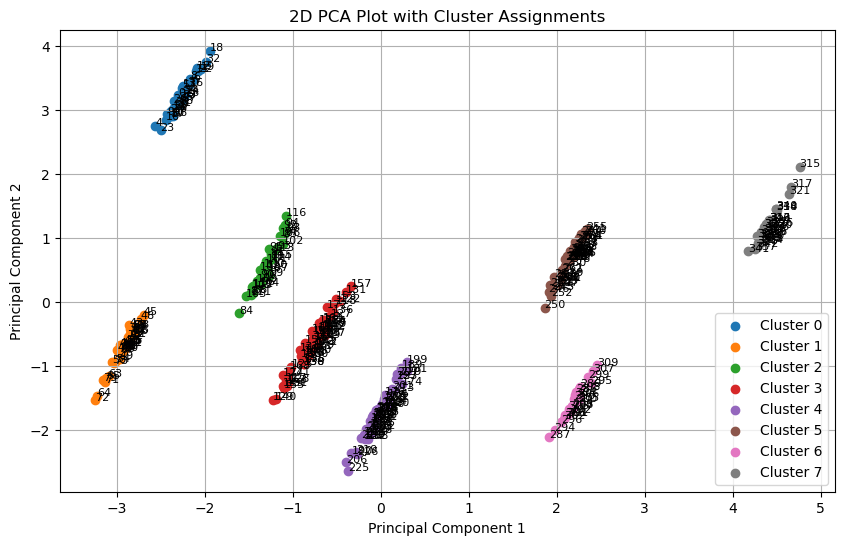

In [71]:
# Assuming 'df' is your original DataFrame with data
# 'cluster_assignments' contains cluster assignments

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(datos_estandarizados_sort)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(arrLabel):
    plt.scatter(df_pca.loc[arrLabel == cluster, 'PC1'],
                df_pca.loc[arrLabel == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [72]:
# Group the data by the 'label' column and calculate the mean of each group
cluster_centroids = datos_estandarizados_sort.groupby('label').mean()
cluster_centroids.round(2)
# 'cluster_centroids' now contains the centroids of each cluster

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
label,,,,
0,0.68,-0.96,1.16,1.24
1,-1.19,0.73,-1.00,-0.77
2,1.37,1.08,-0.04,-0.30
3,-0.51,1.10,-0.42,-0.09
4,-0.99,-0.03,-0.97,-1.12
5,0.24,-1.54,0.79,0.52
6,0.65,0.26,-0.58,-0.75
7,1.29,-0.56,1.73,1.83


In [73]:
# Add the labels as a new column to the DataFrame
datos_estandarizados['label'] = labels
# Sort the DataFrame by the "label" column
df_sort = datos_estandarizados[numericas_estandarizados].sort_values(by="label")

# Group the data by the 'label' column and calculate the mean of each group
cluster_centroids_orig = df_sort.groupby('label').mean()
cluster_centroids_orig.round(2)
# 'cluster_centroids' now contains the centroids of each cluster

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
label,,,,
0,0.68,-0.96,1.16,1.24
1,-1.19,0.73,-1.00,-0.77
2,1.37,1.08,-0.04,-0.30
3,-0.51,1.10,-0.42,-0.09
4,-0.99,-0.03,-0.97,-1.12
5,0.24,-1.54,0.79,0.52
6,0.65,0.26,-0.58,-0.75
7,1.29,-0.56,1.73,1.83
